In [1]:
from lifetimes.datasets import load_cdnow_summary
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from matplotlib import pyplot as plt
from lifetimes.plotting import plot_period_transactions

from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value
from lifetimes import GammaGammaFitter

from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data

from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

from lifetimes.plotting import plot_history_alive

from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

# Basic Frequency/Recency analysis using the BG/NBD model

In [2]:
data = load_cdnow_summary(index_col=[0])

In [3]:
print(data.head())

    frequency  recency      T
ID                           
1           2    30.43  38.86
2           1     1.71  38.86
3           0     0.00  38.86
4           0     0.00  38.86
5           0     0.00  38.86


In [4]:
# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>

In [5]:
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>


In [6]:
print(bgf.summary)

           coef  se(coef)  lower 95% bound  upper 95% bound
r      0.242593  0.012557         0.217981         0.267205
alpha  4.413532  0.378221         3.672218         5.154846
a      0.792886  0.185719         0.428877         1.156895
b      2.425752  0.705345         1.043276         3.808229


## Visualizing our Frequency/Recency Matrix

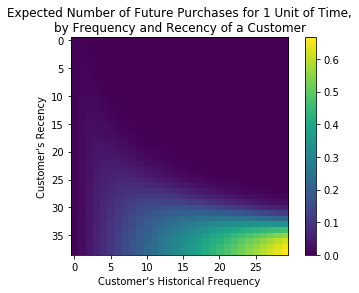

In [7]:
plot_frequency_recency_matrix(bgf)

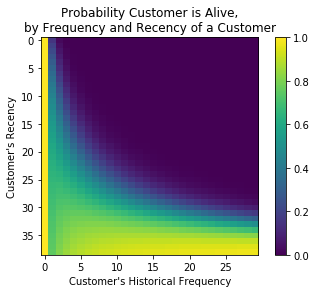

In [8]:
plot_probability_alive_matrix(bgf)

## Ranking customers from best to worst

In [9]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,predicted_purchases
ID,,,,
509,18,35.14,35.86,0.424877
841,19,34.00,34.14,0.474738
1981,17,28.43,28.86,0.486526
157,29,37.71,38.00,0.662396
1516,26,30.86,31.00,0.710623


## Assessing model fit

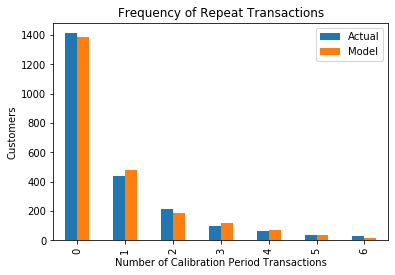

In [10]:
plot_period_transactions(bgf)

# Example using transactional datasets

In [11]:
transaction_data = load_transaction_data()

In [12]:
print(transaction_data.head())

                  date  id
0  2014-03-08 00:00:00   0
1  2014-05-21 00:00:00   1
2  2014-03-14 00:00:00   2
3  2014-04-09 00:00:00   2
4  2014-05-21 00:00:00   2


In [13]:
summary = summary_data_from_transaction_data(transaction_data, 'id', 'date', observation_period_end='2014-12-31')

In [14]:
print(summary.head())

    frequency  recency      T
id                           
0         0.0      0.0  298.0
1         0.0      0.0  224.0
2         6.0    142.0  292.0
3         0.0      0.0  147.0
4         2.0      9.0  183.0


In [15]:
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 5000 subjects, a: 1.85, alpha: 1.86, b: 3.18, r: 0.16>

## More model fitting

In [16]:
summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'id', 'date', calibration_period_end='2014-09-01', observation_period_end='2014-12-31' )

In [17]:
print(summary_cal_holdout.head())

    frequency_cal  recency_cal  T_cal  frequency_holdout  duration_holdout
id                                                                        
0             0.0          0.0  177.0                0.0               121
1             0.0          0.0  103.0                0.0               121
2             6.0        142.0  171.0                0.0               121
3             0.0          0.0   26.0                0.0               121
4             2.0          9.0   62.0                0.0               121


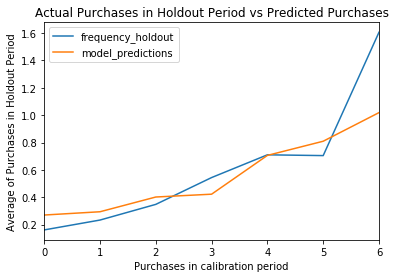

In [18]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [19]:
individual

NameError: name 'individual' is not defined

# Customer Predictions

In [ ]:
t = 10 #predict purchases in 10 periods
individual = summary.iloc[20]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

In [ ]:
##Customer Probability Histories

In [ ]:
id = 35
days_since_birth = 200
sp_trans = transaction_data.loc[transaction_data['id'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')

# Estimating customer lifetime value using the Gamma-Gamma model

In [ ]:
summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value.head()
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]

In [ ]:
print(returning_customers_summary.head())

# The Gamma-Gamma model and the independence assumption

In [ ]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

In [ ]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'], returning_customers_summary['monetary_value'])

In [ ]:
print(ggf)

In [ ]:
print(ggf.conditional_expected_average_profit(summary_with_money_value['frequency'], summary_with_money_value['monetary_value']).head(10))

In [ ]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).mean(),
    summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()
))

In [ ]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'], summary_with_money_value['T'])

In [ ]:
print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary_with_money_value['frequency'],
    summary_with_money_value['recency'],
    summary_with_money_value['T'],
    summary_with_money_value['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

# Saving and loading model

## Fit model

In [ ]:
from lifetimes import BetaGeoFitter
from lifetimes.datasets import load_cdnow_summary

data = load_cdnow_summary(index_col=[0])
bgf = BetaGeoFitter()
bgf.fit(data['frequency'], data['recency'], data['T'])
bgf
"""<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>"""

## Saving model

In [ ]:
bgf.save_model('bgf.pkl')
# or
bgf.save_model('bgf_small_size.pkl', save_data=False, save_generate_data_method=False)

## Loading model

In [ ]:
bgf_loaded = BetaGeoFitter()
bgf_loaded.load_model('bgf.pkl')
bgf_loaded
"""<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>"""

In [ ]:
bgf_loaded